In [40]:
!pip install causalnex

     -------------------------------------- 153.9/153.9 kB 2.3 MB/s eta 0:00:00
     -------------------------------------- 756.0/756.0 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 82.1/82.1 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 134.8/134.8 kB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 56.8/56.8 kB 3.1 MB/s eta 0:00:00
     -------------------------------------- 119.4/119.4 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 46.3/46.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [19]:
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import pandas as pd
file_path = r"C:\Users\user\Desktop\산재보험\2차\df_cleaned.csv"

# CSV 파일 불러오기
df = pd.read_csv(file_path, encoding='utf-8-sig')  # 한글 포함 시 utf-8-sig 권장

drop_cols=[
    "A005A", "A005A03", "A005A04", "A005A05", "A005A06",
    "A005B01", "A005B02", "A005B03", "A005B04", "A005B05", "A005B06",
    "A005C01", "A005C02", "A005C03", "A005C04", "A005C05", "A005C06",
    "A005D01", "A005D02", "A005D03", "A005D04", "A005D05", "A005D06",
    "A005E01", "A005E02", "A005E03", "A005E04", "A005E05", "A005E06",
    "A005F01", "A005F02", "A005F03", "A005F04", "A005F05", "A005F06",
    "A005G01", "A005G02", "A005G03", "A005G04", "A005G05", "A005G06",
    "A005H01", "A005H02", "A005H03", "A005H04", "A005H05", "A005H06",
    "A005I01", "A005I02", "A005I03", "A005I04", "A005I05", "A005I06",
    "A005J01", "A005J02", "A005J03", "A005J04", "A005J05", "A005J06",
    "A005K01", "A005K02", "A005K03", "A005K04", "A005K05", "A005K06",
    "A005L01", "A005L02", "A005L03", "A005L04", "A005L05", "A005L06",
    "A005M01", "A005M02", "A005M03", "A005M04", "A005M05", "A005M06",
    "A005N01", "A005N02", "A005N03", "A005N04", "A005N05", "A005N06",
    "A005O01", "A005O02", "A005O03", "A005O04", "A005O05", "A005O06"
]


df = df.drop(columns=drop_cols, errors='ignore')
# object 타입 열들 삭제
object_cols_to_drop = df.select_dtypes(include='object').columns
df = df.drop(columns=object_cols_to_drop)

#현재 일자리 여부 판단 열 제거(contamination)
d_cols = [col for col in df.columns if col.startswith('D')]
df = df.drop(columns=d_cols)
#마찬가지
e_cols = [col for col in df.columns if col.startswith('E')]
df = df.drop(columns=e_cols)

g_cols = [col for col in df.columns if col.startswith('G013')or col.startswith('G012004')]
df = df.drop(columns=g_cols)


h_cols = [col for col in df.columns if col.startswith('H')]
df = df.drop(columns=h_cols)

i_cols = [col for col in df.columns if col.startswith('I')]
df = df.drop(columns=i_cols)




Columns (51,57,63,69,75,81,87,93,99,105,111,174,176,185,187,196,198,207,209,218,220,229,231,239,241,246,254,256,260,266,281,295,302,307,317,377,381,386,445,449,504,506,510,515,529,538,602,609,611,622,631,671,675,684,689,697,700,765,770,777,787,819,822,824,826,839,852,854,858,860,864,866,894,924,926,961,999,1004,1010,1038,1040,1049,1086,1099,1100,1102,1107,1111,1142,1150,1154,1156,1177,1180,1181,1187,1212,1218,1220,1229,1231,1246,1253,1255,1277,1279,1301,1303,1472,1501,1506,1512,1514,1518,1520,1526,1528,1530,1532,1534,1603,1605,1607,1867,1869,1892,1894) have mixed types. Specify dtype option on import or set low_memory=False.


In [20]:
df

,workperiod14,accident,injurytype,injurypart,con16,acc1,hire1,hire2,gender,age4,...,G026007,G026008,G026009,G026010,G026011,G026012,G027001,G028001,first_yo,second_yo
0,7.0,1.0,1.0,9.0,6.0,2014.0,2013.0,4.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,7.0,1.0,1.0,9.0,6.0,2014.0,2013.0,4.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,7.0,1.0,1.0,9.0,6.0,2014.0,2013.0,4.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,7.0,1.0,1.0,9.0,6.0,2014.0,2013.0,4.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,False,False
4,7.0,1.0,1.0,9.0,6.0,2014.0,2013.0,4.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16465,3.0,1.0,1.0,6.0,2.0,2016.0,2016.0,10.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,False,False
16466,3.0,1.0,1.0,6.0,2.0,2016.0,2016.0,10.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,False,False
16467,3.0,1.0,1.0,6.0,2.0,2016.0,2016.0,10.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,True,True
16468,3.0,1.0,1.0,6.0,2.0,2016.0,2016.0,10.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,False,False


# Catboost+shap

In [22]:

target_col1 = 'first_yo' 
target_col2 = 'second_yo'


X = df.drop(columns=[target_col2,target_col1])
y = df[target_col2]



In [23]:
#second_yo
import pandas as pd
from catboost import CatBoostClassifier, Pool

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_cols,
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)


# 5. SHAP 분석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 6. SHAP 요약 플롯
shap.summary_plot(shap_values, X_test, max_display=20)


NameError: name 'categorical_cols' is not defined

In [24]:

df = df.drop('first_yo', axis=1, errors='ignore')

target_col = 'second_yo'

X = df.drop(columns=[target_col])
y = df[target_col]

# 1. 범주형/수치형 변수 분리 기준 = 고유값 수
categorical_cols = []
numeric_cols = []


0:	learn: 0.6618107	test: 0.6631415	best: 0.6631415 (0)	total: 50.7ms	remaining: 25.3s
100:	learn: 0.3821383	test: 0.4085087	best: 0.4085087 (100)	total: 5.66s	remaining: 22.3s
200:	learn: 0.3519150	test: 0.3965277	best: 0.3965277 (200)	total: 12.3s	remaining: 18.3s
300:	learn: 0.3192120	test: 0.3855574	best: 0.3855574 (300)	total: 17.4s	remaining: 11.5s
400:	learn: 0.2943353	test: 0.3788953	best: 0.3788953 (400)	total: 22.1s	remaining: 5.46s
499:	learn: 0.2716350	test: 0.3705131	best: 0.3705131 (499)	total: 26.3s	remaining: 0us

bestTest = 0.3705131003
bestIteration = 499



Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


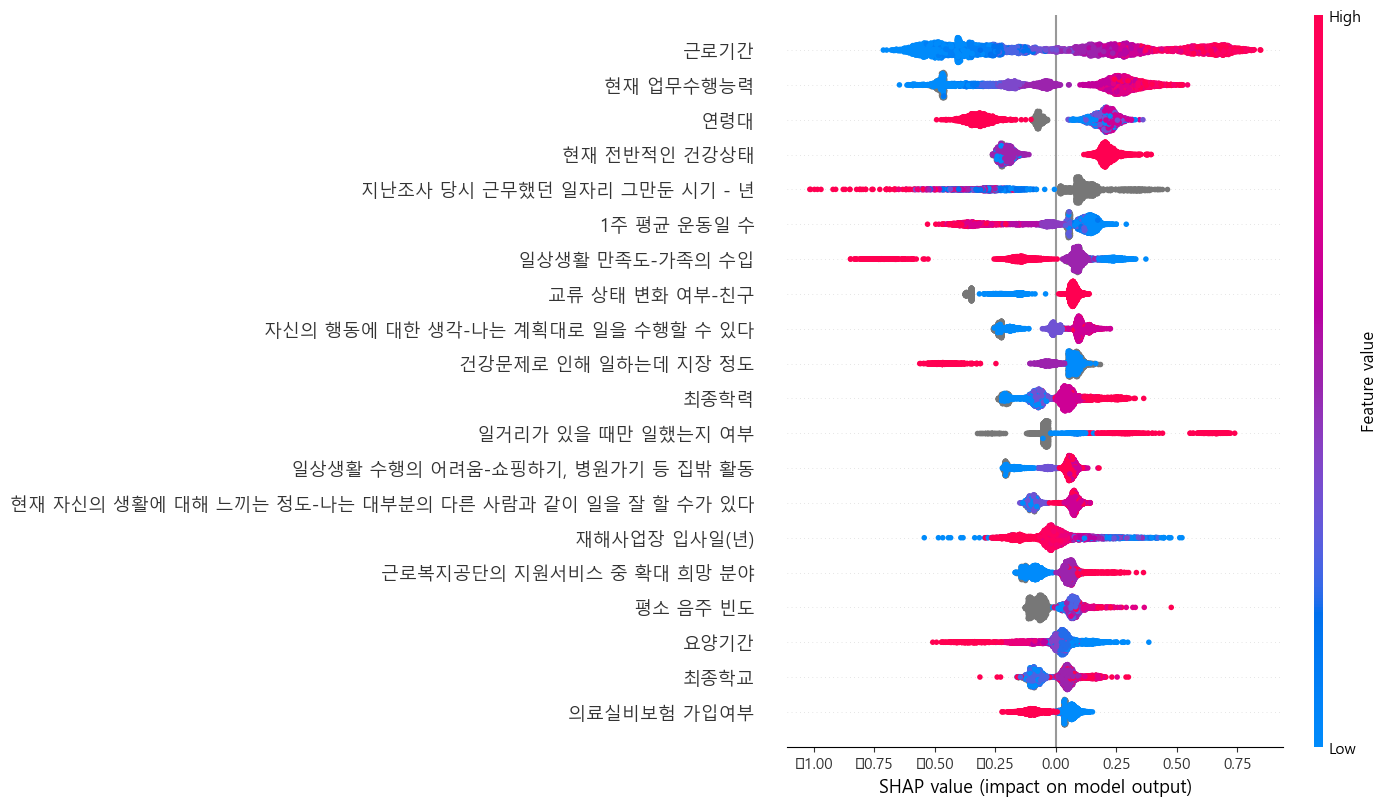

In [27]:
#firtst _yo 

import pandas as pd
from catboost import CatBoostClassifier, Pool

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_cols,
    verbose=100,
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

import shap
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# === 1. 한글 폰트 설정 ===
font_path = r"C:\Windows\Fonts\malgun.ttf"  # 또는 NanumGothic.ttf
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# === 2. 변수명 매핑 JSON 로드 ===
with open(r"C:\Users\user\Desktop\산재보험\variable_dict.json", "r", encoding='utf-8-sig') as f:
    variable_dict = json.load(f)

# === 3. 변수명 한글로 변환 함수 ===
def get_korean_name(col_name):
    return variable_dict.get(col_name, col_name)

# === 4. SHAP 분석 ===
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# === 5. 한글 변수명으로 컬럼명 매핑 ===
X_test_korean = X_test.copy()
X_test_korean.columns = [get_korean_name(col) for col in X_test.columns]

# === 6. SHAP Summary Plot ===
shap.summary_plot(shap_values, X_test_korean, max_display=20)



In [28]:
from itertools import combinations
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
import json

# === 1. 딕셔너리 불러오기 (영문 → 한글)
with open(r"C:\Users\user\Desktop\산재보험\variable_dict.json", "r", encoding='utf-8-sig') as f:
    variable_dict = json.load(f)
def to_kor(var): return variable_dict.get(var, var)

# === 2. 기존 변수 중요도 측정 (Mutual Info 기반)
mi_base = mutual_info_classif(X_encoded, y, discrete_features='auto', random_state=42)
mi_base_series = pd.Series(mi_base, index=X_encoded.columns).sort_values(ascending=False)

# === 3. 조합 생성
top_k = 12         # 상위 변수 몇 개로 조합할지
min_comb = 2       # 최소 변수 개수
max_comb = 4       # 최대 변수 개수

top_features = mi_base_series.head(top_k).index.tolist()
combined_features = []

for r in range(min_comb, max_comb + 1):
    combined_features += list(combinations(top_features, r))

print(f"🔍 생성된 복합 변수 조합 수: {len(combined_features)}")

# === 4. 복합 변수 생성
X_aug = X_encoded.copy()
new_feature_names = []

for comb in combined_features:
    col_name = "_x_".join(comb)
    X_aug[col_name] = X_encoded[list(comb)].prod(axis=1)
    new_feature_names.append(col_name)

# === 5. Mutual Info 계산
mi_all = mutual_info_classif(X_aug[new_feature_names], y, discrete_features='auto', random_state=42)
mi_result = pd.Series(mi_all, index=new_feature_names).sort_values(ascending=False)

# === 6. 한글 이름 매핑 후 결과 출력
print("\n✅ 상위 복합 변수 조합 (한글 매핑):")
for i, (feat, score) in enumerate(mi_result.head(15).items(), 1):
    kor_name = " × ".join([to_kor(x) for x in feat.split("_x_")])
    print(f"{i:2d}. {kor_name} → {score:.4f}")


ValueError: Input X contains NaN.

In [30]:
import pandas as pd

# 순위별 조합과 중요도 리스트
combinations_data = [
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 자신의 행동에 대한 생각-자신감이 있다", 0.1487),
    ("현재 전반적인 건강상태, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구, 자신의 행동에 대한 생각-자신감이 있다", 0.1470),
    ("현재 전반적인 건강상태, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구, 현재 자신의 생활에 대해 느끼는 정도-나는 대부분의 다른 사람과 같이 일을 잘 할 수가 있다", 0.1451),
    ("현재 전반적인 건강상태, 현재 업무수행능력, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 자신의 행동에 대한 생각-자신감이 있다", 0.1450),
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 교류 상태 변화 여부-친구", 0.1445),
    ("현재 전반적인 건강상태, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 교류 상태 변화 여부-친구, 자신의 행동에 대한 생각-자신감이 있다", 0.1443),
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 교류 상태 변화 여부-친구, 현재 자신의 생활에 대해 느끼는 정도-나는 대부분의 다른 사람과 같이 일을 잘 할 수가 있다", 0.1437),
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 자신의 행동에 대한 생각-자신감이 있다", 0.1437),
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구", 0.1436),
    ("현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 교류 상태 변화 여부-친구", 0.1434),
    ("현재 전반적인 건강상태, 현재 업무수행능력, 자신의 행동에 대한 생각-자신감이 있다", 0.1434),
    ("현재 전반적인 건강상태, 현재 업무수행능력, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 자신의 행동에 대한 생각-자신감이 있다", 0.1429),
    ("현재 전반적인 건강상태, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 교류 상태 변화 여부-친구", 0.1428),
    ("현재 전반적인 건강상태, 현재 업무수행능력, 교류 상태 변화 여부-친구, 현재 자신의 생활에 대해 느끼는 정도-나는 대부분의 다른 사람과 같이 일을 잘 할 수가 있다", 0.1426),
    ("현재 전반적인 건강상태, 현재 업무수행능력, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다", 0.1426),
]

# DataFrame으로 변환
df_comb = pd.DataFrame(combinations_data, columns=["복합 변수 조합", "중요도"])
df_comb.index = df_comb.index + 1
df_comb.index.name = "순위"

from IPython.display import display, HTML

# 전체 텍스트 wrap 해서 출력
display(HTML(df_comb.to_html(index=True, escape=False)))




,복합 변수 조합,중요도
순위,,
1,"현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 자신의 행동에 대한 생각-자신감이 있다",0.1487
2,"현재 전반적인 건강상태, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구, 자신의 행동에 대한 생각-자신감이 있다",0.1470
3,"현재 전반적인 건강상태, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구, 현재 자신의 생활에 대해 느끼는 정도-나는 대부분의 다른 사람과 같이 일을 잘 할 수가 있다",0.1451
4,"현재 전반적인 건강상태, 현재 업무수행능력, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 자신의 행동에 대한 생각-자신감이 있다",0.1450
5,"현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 교류 상태 변화 여부-친구",0.1445
6,"현재 전반적인 건강상태, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 교류 상태 변화 여부-친구, 자신의 행동에 대한 생각-자신감이 있다",0.1443
7,"현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 교류 상태 변화 여부-친구, 현재 자신의 생활에 대해 느끼는 정도-나는 대부분의 다른 사람과 같이 일을 잘 할 수가 있다",0.1437
8,"현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-옷입기, 목욕하기 등 집안 활동, 자신의 행동에 대한 생각-자신감이 있다",0.1437
9,"현재 전반적인 건강상태, 자신의 행동에 대한 생각-나는 계획대로 일을 수행할 수 있다, 일상생활 수행의 어려움-쇼핑하기, 병원가기 등 집밖 활동, 교류 상태 변화 여부-친구",0.1436


# Bayesian Network

In [4]:

target_col1 = 'first_yo' 
target_col2 = 'second_yo'


df_b = df.drop(columns=[target_col2])

In [89]:
col_info = []

for col in data.columns:
    dtype = data[col].dtype
    nunique = data[col].nunique(dropna=False)
    col_info.append((col, dtype, nunique))
print(len(data.columns))
# 보기 좋게 DataFrame으로 정리
col_df = pd.DataFrame(col_info, columns=['column', 'dtype', 'n_unique (with NaN)'])

# unique 값 기준 정렬 (옵션)
col_df = col_df.sort_values(by='n_unique (with NaN)')

# 출력
# 전체 데이터프레임의 고유한 데이터 타입 목록 보기
print(data.dtypes.unique())
n_unique_limit = 12
n_small_unique_cols = sum(data.nunique(dropna=False) <= n_unique_limit)

print(f"✅ 유니크 값 개수가 {n_unique_limit} 이하인 열의 개수: {n_small_unique_cols}")

# 각 dtype별 열 개수까지 보기
print(data.dtypes.value_counts())

print(col_df)



718
[dtype('float64') dtype('int32')]
✅ 유니크 값 개수가 12 이하인 열의 개수: 632
int32      632
float64     86
dtype: int64
      column    dtype  n_unique (with NaN)
621  G006018    int32                    1
489  F003F18    int32                    1
488  F003F17    int32                    1
487  F003F16    int32                    1
486  F003F15    int32                    1
..       ...      ...                  ...
623  G007002  float64                  100
625  G007004  float64                  105
622  G007001  float64                  114
146  B009002  float64                  118
322  C021001  float64                  143

[718 rows x 3 columns]


In [75]:
def diagnose_first_yo_issue(df_cat, target='first_yo'):
    print("📊 [1] first_yo 클래스 분포 확인")
    print(df_cat[target].value_counts(dropna=False))
    print(df_cat[target].value_counts(normalize=True), "\n")
    
    # 불균형 판단
    value_counts = df_cat[target].value_counts(normalize=True)
    imbalance = (value_counts.max() > 0.9)
    if imbalance:
        print("⚠️ [!] first_yo 클래스가 매우 불균형합니다 (90% 이상이 한쪽).")
    else:
        print("✅ first_yo 클래스는 비교적 균형 잡혀 있습니다.")
    
    print("\n📊 [2] 변수별 'missing' 비율 확인 (구조적 결측 진단)")
    missing_ratio = df_cat.apply(lambda col: (col.astype(str) == "missing").mean())
    high_missing = missing_ratio[missing_ratio > 0.5]
    
    if len(high_missing) > 0:
        print(f"⚠️ [!] 총 {len(high_missing)}개의 변수에서 'missing'이 50%를 넘습니다.")
        print(high_missing.sort_values(ascending=False))
    else:
        print("✅ 'missing' 비율이 50% 이상인 변수는 없습니다.")
    
    print("\n📊 [3] 타겟과 다른 변수들의 고유값 수 비교 (정보 밀도 진단)")
    info_density = df_cat.drop(columns=[target]).nunique()
    low_info = info_density[info_density <= 1]
    
    if len(low_info) > 0:
        print(f"⚠️ [!] 총 {len(low_info)}개의 변수는 정보량이 거의 없습니다 (고유값이 1 이하).")
        print(low_info)
    else:
        print("✅ 모든 변수는 최소한의 정보량을 가지고 있습니다.")

from sklearn.metrics import mutual_info_score

def diagnose_structure_learning(df_cat, graph, target='first_yo'):
    print("📊 [A] first_yo와의 Mutual Information (통계적 연관도):")
    mi_scores = []
    for col in df_cat.columns:
        if col == target:
            continue
        mi = mutual_info_score(df_cat[col], df_cat[target])
        mi_scores.append((col, mi))

    mi_scores_sorted = sorted(mi_scores, key=lambda x: x[1], reverse=True)
    for var, mi in mi_scores_sorted[:10]:
        print(f"{var}: MI = {mi:.4f}")
    
    print("\n📊 [B] 베이지안 네트워크에 first_yo 포함 여부:")
    has_node = target in graph.nodes
    has_edge = any([target in edge for edge in graph.edges])
    print(f"✅ first_yo in graph.nodes: {has_node}")
    print(f"✅ first_yo in graph.edges: {has_edge}")
    
    print("\n📊 [C] 전체 그래프 구조 요약:")
    print(f"총 노드 수: {len(graph.nodes)}")
    print(f"총 엣지 수: {len(graph.edges)}")
    if len(graph.edges) < 5:
        print("⚠️ 전체 그래프가 너무 희소합니다. threshold를 낮추는 것을 고려하세요.")
    
    print("\n📊 [D] first_yo와 각 변수의 동시 비결측 샘플 수:")
    valid_counts = {}
    for col in df_cat.columns:
        if col == target:
            continue
        joint_valid = df_cat[(df_cat[col] != 'missing') & (df_cat[target] != 'missing')]
        valid_counts[col] = len(joint_valid)
    
    valid_counts_sorted = sorted(valid_counts.items(), key=lambda x: x[1])
    for col, count in valid_counts_sorted[:10]:
        print(f"{col}: 유효 샘플 수 = {count}")


In [76]:
from causalnex.structure.notears import from_pandas

# 기존 df_cat이 범주형 처리된 DataFrame이라고 가정
# 구조 학습 먼저 수행
sm = from_pandas(df_cat)

# 진단 실행
diagnose_structure_learning(df_cat, sm)


📊 [A] first_yo와의 Mutual Information (통계적 연관도):

📊 [B] 베이지안 네트워크에 first_yo 포함 여부:
✅ first_yo in graph.nodes: True
✅ first_yo in graph.edges: False

📊 [C] 전체 그래프 구조 요약:
총 노드 수: 1
총 엣지 수: 0
⚠️ 전체 그래프가 너무 희소합니다. threshold를 낮추는 것을 고려하세요.

📊 [D] first_yo와 각 변수의 동시 비결측 샘플 수:


In [17]:
import pandas as pd
import numpy as np

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ✨ 데이터 로딩
data = df_b.copy()
y = data["first_yo"]
X = data.drop(columns=["first_yo"])

# ✨ 결측 마스크 생성 (구조적 결측을 명시적으로 반영)
X_mask = X.isnull().astype(int)

# ✨ 간단한 전처리 (연속형: 평균 대치, 범주형: 최빈값)
for col in X.columns:
    if X[col].dtype == "object" or X[col].nunique() <= 12:
        X[col] = X[col].fillna(X[col].mode()[0])
        X[col] = LabelEncoder().fit_transform(X[col])
    else:
        X[col] = X[col].fillna(X[col].mean())

# ✨ 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✨ PyTorch Dataset
class SurveyDataset(Dataset):
    def __init__(self, X, y, mask):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
        self.mask = torch.tensor(mask.values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.mask[idx]

dataset = SurveyDataset(X_scaled, y, X_mask)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# ✨ CEVAE 구조 (간단 버전)
class CEVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 2 * latent_dim)  # mean, logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        q_params = self.encoder(x)
        mu, logvar = torch.chunk(q_params, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        y_pred = self.decoder(z)
        return y_pred, mu, logvar

model = CEVAE(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# ✨ 학습 루프
def train(model, loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch, _ in loader:
            optimizer.zero_grad()
            y_pred, mu, logvar = model(X_batch)
            recon_loss = loss_fn(y_pred, y_batch)
            kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_div * 0.001
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[{epoch+1}] Loss: {total_loss:.4f}")

train(model, train_loader)

# 3. 구조적 결측치 컬럼 생성
# ----------------------------------
missing_flags = pd.DataFrame({
    f"{col}_is_missing": X[col].isnull().astype(int)
    for col in X.columns if X[col].isnull().any()
})
print(f"추가되는 결측 여부 컬럼 수: {missing_flags.shape[1]}")

# concat
X = pd.concat([X, missing_flags], axis=1)
X = X.copy()  # 파편화 제거
print(f"결측 여부 컬럼 추가 후 X shape: {X.shape}")

# ----------------------------------
# 4. 결측치 대체
# ----------------------------------
imputer = SimpleImputer(strategy='constant', fill_value=-999)
X_imputed_np = imputer.fit_transform(X)
print(f"Imputed numpy array shape: {X_imputed_np.shape}")

# 열 이름 수 체크
assert X_imputed_np.shape[1] == X.shape[1], "열 수 불일치 오류 발생!"

# 다시 DataFrame으로 변환
X_imputed = pd.DataFrame(X_imputed_np, columns=X.columns)

# ----------------------------------
# 5. 처치 변수 정의 (임시)
# ----------------------------------
T = np.ones_like(y)

# ----------------------------------
# 6. 데이터 분할
# ----------------------------------
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    X_imputed, y, T, test_size=0.2, random_state=42
)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# ----------------------------------
# 7. Causal Forest 모델 정의 및 학습
# ----------------------------------
from sklearn.linear_model import RidgeCV

model = CausalForestDML(
    model_t=RandomForestClassifier(n_estimators=100),
    model_y=RidgeCV(),  # 안정적이고 빠름
    discrete_treatment=True,
    random_state=0
)

print("🔍 X_train info")
print("type:", type(X_train))
print("shape:", X_train.shape)
print("dtypes:\n", X_train.dtypes.value_counts())
print("nulls:", X_train.isnull().sum().sum())

print("\n🔍 y_train info")
print("type:", type(y_train))
print("shape:", y_train.shape)
print("unique values:", np.unique(y_train))

print("\n🔍 T_train info")
print("type:", type(T_train))
print("shape:", T_train.shape)
print("unique values:", np.unique(T_train))

model.fit(Y=y_train, T=T_train, X=X_train)
print("모델 학습 완료!")

# ----------------------------------
# 8. SHAP 해석
# ----------------------------------
explainer = shap.Explainer(model.model_y, X_train)
shap_values = explainer(X_train)

# 시각화
shap.summary_plot(shap_values, X_train, max_display=20)


KeyError: 0